In [910]:
%pylab inline
import pympedance.Synthesiser as psy
from vocalsims.fitting import vectfit as vfit
import json
import importlib.resources as ires
import vocalsim_parameters.vocal_tracts as vts
import scipy.signal as sig

Populating the interactive namespace from numpy and matplotlib


/Users/goios/Envs/unsw/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [911]:
with ires.open_text(vts,"vt_all.json") as f:
    tractjs = json.load(f)

In [912]:


[(ii,s) for ii,s in enumerate(tractjs) if s['headers']['phoneme']=='a']

[(5,
  {'headers': {'phoneme': 'a',
    'file': 'Story1996_male01_cm2.csv',
    'units': 'cm2',
    'gender': 'male',
    'source': 'Story 1996',
    'delta': 0.396285,
    'length ': 17.46,
    'measured_formants': {'f1': 754, 'f2': 1195, 'f3': 2685}},
   'radii': [0.45,
    0.2,
    0.26,
    0.21,
    0.32,
    0.3,
    0.33,
    1.05,
    1.12,
    0.85,
    0.63,
    0.39,
    0.26,
    0.28,
    0.23,
    0.32,
    0.29,
    0.28,
    0.4,
    0.66,
    1.2,
    1.05,
    1.62,
    2.09,
    2.56,
    2.78,
    2.86,
    3.02,
    3.75,
    4.6,
    5.09,
    6.02,
    6.55,
    6.29,
    6.27,
    5.94,
    5.28,
    4.7,
    3.87,
    4.13,
    4.25,
    4.27,
    4.69,
    5.03]}),
 (35,
  {'headers': {'phoneme': 'a',
    'file': 'Story1998_female_cm2.csv',
    'units': 'cm2',
    'gender': 'female',
    'source': 'Story 1998',
    'delta': 0.396825,
    'unnamed_3': 18,
    'unnamed_6': 23,
    'unnamed_9': 96,
    'measured_formants': {'f1': 961, 'f2': 1488, 'f3': 2779}},
  

In [913]:
psy.Duct?

Init signature: psy.Duct(world=None, losses=True)
Docstring:      1-D duct object containing linear elements
File:           ~/Devel/impedancepython/pympedance/Synthesiser.py
Type:           type
Subclasses:     


In [914]:
def get_impedance(tract, loss_multiplier=5):
    delta = tract['headers']['delta']
    units = tract['headers']['units']
    if units == 'cm2':
        unit_mult = .01
    duct = psy.Duct()
    for csect in tract['radii']:
        if units == 'cm2':
            rr = np.sqrt(csect/pi)*unit_mult
        duct.append_element(psy.StraightDuct(radius=rr,length=delta*unit_mult,loss_multiplier=loss_multiplier))
    duct.set_termination(psy.PerfectClosedEnd())
    return duct

/Users/goios/Devel/impedancepython/pympedance/Synthesiser.py:1004: RuntimeWarning: divide by zero encountered in true_divide
  return (1.+r)/(1.-r)


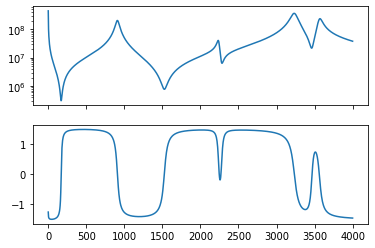

In [915]:
f=np.linspace(1,4000,1000)
duct = get_impedance(tractjs[5],loss_multiplier=2)
z=duct.get_input_impedance_at_freq(f)


fig,ax=subplots(2,sharex=True)
ax[0].semilogy(f,np.abs(z))
ax[1].plot(f,np.angle(z))

In [916]:
pks,_ = sig.find_peaks(np.abs(z),width=1)
vls,_ = sig.find_peaks(-np.abs(z),width=1)
print(f[pks],f[vls])
if vls[0]>pks[0]:
    istop = int((vls[0]+pks[0])/2)
else:
    istop = int((vls[1]+pks[0])/2)

[ 909.68168168 2234.67567568 3231.42342342 3571.67867868] [ 169.12612613 1526.14414414 2282.71171171 3463.5975976 ]


In [917]:
s = 1j*2*np.pi*f
zvar = s
hf=z/duct.char_impedance


pf,zf,df,rf=vfit.vectfit_auto(hf[:istop],zvar[:istop],n_poles=1)

poles: -150.782 + -5704.52j, -150.782 + 5704.52j
residues: 3337.85 + -176.428j, 3337.85 + 176.428j
offset: 0.13691
slope: 6.7698e-05


/Users/goios/Devel/impedancepython/pympedance/Synthesiser.py:1004: RuntimeWarning: divide by zero encountered in true_divide
  return (1.+r)/(1.-r)


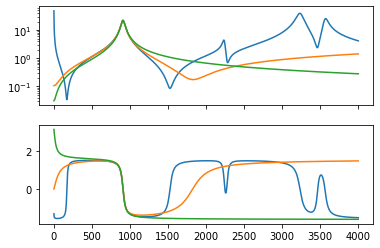

In [918]:
f=np.linspace(1,4000,1000)
duct = get_impedance(tractjs[5])
z=duct.get_input_impedance_at_freq(f)


fig,ax=subplots(2,sharex=True)
ax[0].semilogy(f,np.abs(hf))
ax[1].plot(f,np.angle(hf))
ax[0].semilogy(f,np.abs(vfit.model(zvar,pf,zf,df,rf)))
ax[1].plot(f,np.angle(vfit.model(zvar,pf,zf,df,rf)))
ax[0].semilogy(f,np.abs(vfit.model(zvar,pf,zf,0,0)))
ax[1].plot(f,np.angle(vfit.model(zvar,pf,zf,0,0)))

In [919]:
zf[0]/(0-pf[0])+zf[0].conj()/(0-pf[0].conj())

(-0.030901846069671546+0j)

In [920]:
# def model(s, poles, residues, poly_coefs):
#     return sum(r/(s-p) for p, r in zip(poles, residues)) + sum(s**i*pc for i,pc in enumerate(poly_coefs))

def model(s, poles, residues, poly_coefs):
    ret = np.zeros(len(s),dtype='complex')
    for p, r in zip(poles, residues):
        ret += r/(s-p)
    for i,pc in enumerate(poly_coefs):
        ret += s**i*pc
    return ret


def vecfit_lin_syst(f,s,poles, weights=None, poly_degree=-1):
    """
    Calculate A and b in system Ax=b for the fitting of poles
    """
    N = len(poles)
    Ns = len(s)
    Npoly = poly_degree+1

    cindex = zeros(N)
    # cindex is:
    #   - 0 for real poles
    #   - 1 for the first of a complex-conjugate pair
    #   - 2 for the second of a cc pair
    for i, p in enumerate(poles):
        if p.imag != 0:
            if i == 0 or cindex[i-1] != 1:
                assert (poles[i].conj()) == poles[i+1], ("Complex poles must come in conjugate pairs: %s, %s" % (poles[i], poles[i+1]))
                cindex[i] = 1
            else:
                cindex[i] = 2

    # First linear equation to solve. See Appendix A
    A = zeros((Ns, 2*N+Npoly), dtype=np.complex64)
    for i, p in enumerate(poles):
        if cindex[i] == 0:
            A[:, i] = 1/(s - p)
        elif cindex[i] == 1:
            A[:, i] = 1/(s - p) + 1/(s - p.conj())
        elif cindex[i] == 2:
            A[:, i] = 1j/(s - p) - 1j/(s - p.conj())
        else:
            raise RuntimeError("cindex[%s] = %s" % (i, cindex[i]))

        A [:, N+Npoly+i] = -A[:, i] * f

    for i in range(Npoly):
        A[:, N+i] = s**i

    # Solve Ax == b using pseudo-inverse
    b = f
    
    if weights is not None:
        A *= np.tile(weights[:,np.newaxis],(1,A.shape[1]))
        b = f*weights
        
    return A, b, cindex

def vecfit_step(f,s,poles, weights, poly_degree=-1):
    """
    
    fit s, a for 
    
        f = \Sum_i(r/(s-p_i)) + \Sum_{i=0}^{poly_degree} (a_i * s i)
    
    f = complex data to fit
    s = j*frequency
    poles = initial poles guess
        note: All complex poles must come in sequential complex conjugate pairs
    poly_degree = maximum degree of polynomial terms 
    returns adjusted poles
    """
 
    N = len(poles)
    Npoly = poly_degree+1

    # Calculate the complex matrix to solve 
    A, b, cindex = vecfit_lin_syst(f,s,poles, weights=weights, poly_degree=poly_degree)
    
    # Separate real and imaginary parts
    A = vstack((real(A), imag(A)))
    b = concatenate((real(b), imag(b)))
    x, residuals, rnk, s = lstsq(A, b, rcond=-1)

    residues = x[:N]
    poly_coefs = np.zeros(Npoly)
    poly_coefs = x[N:N+Npoly]

    # We only want the "tilde" part in (A.4)
    x = x[-N:]

    # Calculation of zeros: Appendix B
    A = diag(poles)
    b = ones(N)
    c = x
    for i, (ci, p) in enumerate(zip(cindex, poles)):
        if ci == 1:
            x, y = real(p), imag(p)
            A[i, i] = A[i+1, i+1] = x
            A[i, i+1] = -y
            A[i+1, i] = y
            b[i] = 2
            b[i+1] = 0
            #cv = c[i]
            #c[i,i+1] = real(cv), imag(cv)

    H = A - outer(b, c)
    H = real(H)
    new_poles = sort(eigvals(H))
    unstable = real(new_poles) > 0
    new_poles[unstable] -= 2*real(new_poles)[unstable]
    return new_poles


def calculate_residues(f, s, poles, weights, poly_degree=-1, rcond=-1, force_residue=None):
    
    N = len(poles)
    Npoly = poly_degree+1
    
    # Calculate the complex matrix to solve 
    A, b, cindex = vecfit_lin_syst(f,s,poles,weights=weights,poly_degree=poly_degree)

    if force_residue == "imag":
        A = A[:,0:N:2]
    elif force_residue == "arg_pole":
        arg_poles = angle(poles[0:N:2])
        A = A[:,0:N:2] * cos(arg_poles)
        #A[:,1:N:2] *= sin(arg_poles)

    # Solve Ax == b using pseudo-inverse
    A = vstack((real(A), imag(A)))
    b = concatenate((real(b), imag(b)))

    
    cA = np.linalg.cond(A)
    if cA > 1e13:
        print ('Warning!: Ill Conditioned Matrix. Consider scaling the problem down')
        print ('Cond(A)', cA)
    x, residuals, rnk, s = lstsq(A, b, rcond=rcond)

    # Recover complex values
    x = np.complex64(x)
    if force_residue=="imag":
        x = np.concatenate([[-1j*xx,1j*xx] for xx in x])
    elif force_residue == "arg_pole":
        x = np.concatenate([[xx*exp(1j*arg),xx*exp(-1j*arg)] for xx,arg in zip(x,arg_poles)])
        
    else:
        for i, ci in enumerate(cindex):
            if ci == 1:
                r1, r2 = x[i:i+2]
                x[i] = r1 - 1j*r2
                x[i+1] = r1 + 1j*r2

    residues = x[:N]
    poly_coefs = x[N:N+Npoly].real
    return residues, poly_coefs


def print_params(poles, residues, poly_coefs):
    cfmt = "{0.real:g} + {0.imag:g}j"
    print ("poles: " + ", ".join(cfmt.format(p) for p in poles))
    print ("residues: " + ", ".join(cfmt.format(r) for r in residues))
    
    print("polynomial coefs: ")
    pcs=""
    for ii, pc in enumerate(poly_coefs):
        if ii>0:
            pcs += " + "
        pcs+=f"{pc:g} s**{ii}"

    print (pcs) 
    
def vecfit_auto(f, s, weights=None, n_poles=10, poly_degree=-1, 
                n_iter=10, show=False,
                inc_real=False, loss_ratio=1e-2, rcond=-1, 
                track_poles=False, init_resonances=None, force_residue=None):
    w = imag(s)
    if init_resonances is None: 
        pole_locs = linspace(w[0], w[-1], n_poles+2)[1:-1]
    else:
        pole_locs = init_resonances
        
    lr = loss_ratio
    init_poles = poles = concatenate([[p*(-lr + 1j), p*(-lr - 1j)] for p in pole_locs])

    if inc_real:
        poles = concatenate((poles, [1]))
        
    if weights is None:
        weights = ones(f.shape)

    poles_list = []
    for _ in range(n_iter):
        poles = vecfit_step(f, s, poles, weights=weights, poly_degree=poly_degree)
        poles_list.append(poles)

    residues, poly_coefs = calculate_residues(f, s, poles, weights=weights, poly_degree=poly_degree, rcond=rcond, force_residue=force_residue)

    if track_poles:
        return poles, residues, poly_coefs, np.array(poles_list)

    print_params(poles, residues, poly_coefs)
    return poles, residues, poly_coefs



In [921]:
n_poles = 4

pks,_ = sig.find_peaks(np.abs(z),width=10)
vls,_ = sig.find_peaks(-np.abs(z),width=10)

print(f[pks],f[vls])
if vls[0]>pks[0]:
    try:
        istop = int((vls[n_poles-1]+pks[n_poles-1])/2)
    except IndexError:
        istop = len(z)
    istart = 0
else:
    istart=vls[0]
    try:
        istop = int((vls[n_poles]+pks[n_poles-1])/2)
    except IndexError:
        istop = len(z)

    
weights = f[istart:istop]**(-1)
weights = np.abs(zvar[istart:istop])**(-.5)

fres = 2*pi*f[pks[:n_poles]]

if len(fres)<n_poles:
    fres = np.concatenate([fres,fres[-1]+np.arange(1,n_poles-len(fres)+1)*4*np.median(np.diff(fres))])

pf,zf,pcf = vecfit_auto(hf[istart:istop],zvar[istart:istop],n_poles=n_poles,weights = weights,init_resonances=fres)#,force_residue="arg_pole"  )

[ 905.67867868 2218.66366366 3223.41741742 3591.69369369] [ 169.12612613 1530.14714715 2298.72372372 3455.59159159]
poles: -279.547 + -20317.6j, -279.547 + 20317.6j, -202.779 + -22392.9j, -202.779 + 22392.9j, -151.775 + -5715.41j, -151.775 + 5715.41j, -102.361 + -14062.7j, -102.361 + 14062.7j
residues: 11079.9 + 389.887j, 11079.9 + -389.887j, 4954.06 + -847.726j, 4954.06 + 847.726j, 3367.04 + -31.9087j, 3367.04 + 31.9087j, 391.769 + -21.9235j, 391.769 + 21.9235j
polynomial coefs: 



In [922]:
fres

array([ 5690.5469669 , 13940.2749331 , 20253.32895602, 22567.27704411])

/Users/goios/Devel/impedancepython/pympedance/Synthesiser.py:1004: RuntimeWarning: divide by zero encountered in true_divide
  return (1.+r)/(1.-r)


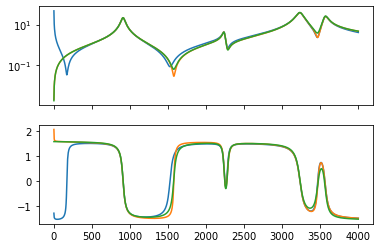

In [923]:
f=np.linspace(1,4000,1000)
duct = get_impedance(tractjs[5])
z=duct.get_input_impedance_at_freq(f)


fig,ax=subplots(2,sharex=True)
ax[0].semilogy(f,np.abs(hf))
ax[1].plot(f,np.angle(hf))
ax[0].semilogy(f,np.abs(model(zvar,pf,zf,pcf)))
ax[1].plot(f,np.angle(model(zvar,pf,zf,pcf)))

zfc = np.abs(zf)*np.exp(1j*(np.angle(pf)))
zfc[zfc.imag>0]*=-1j
zfc[zfc.imag<0]*=+1j
ax[0].semilogy(f,np.abs(model(zvar,pf,zfc,pcf)))
ax[1].plot(f,np.angle(model(zvar,pf,zfc,pcf)))


In [924]:
from scipy.optimize import minimize, basinhopping

In [927]:
def classify_poles(poles,eps=1e-12):
    cindex = np.zeros(len(poles))
    pairs = []
    for ii,pp in enumerate(poles):
        if np.abs(pp.imag)>eps:
            if pp.imag<0:
                pdist = np.abs(poles-pp.conj())
                imin = np.argmin(pdist)
                if pdist[imin]<eps:
                    pairs.append((ii,imin))
                    cindex[ii]=1
                    cindex[imin]=2
                else:
                    raise ValueError
    return cindex,pairs
    

class VFTweaker(object):
#     def model(self, s, poles, residues, poly_coefs):
#         return sum(r/(s-p) for p, r in zip(poles, residues)) + sum(s**i*pc for i,pc in enumerate(poly_coefs))

    def model(self, s, poles, residues, poly_coefs):
        ret = np.zeros(len(s),dtype='complex')
        for p, r in zip(poles, residues):
            ret += r/(s-p)
        for i,pc in enumerate(poly_coefs):
            ret += s**i*pc
        return ret

    def model_jac(self, s, poles, residues, poly_coefs):
        dfdpoles = np.array([-rr/(s-pp) for rr, pp in residues, poles])
        dfdresidues = np.array([1/(s-pp) for rr, pp in residues, poles])
        dfdpoly = np.array([s**ii for ii, pp in poly_coefs])
        return dfdpoles, dfdresidues, dfdpoly
        
    def __init__(self,f,s,poles,residues,poly_coefs=None,residues_only=True,copy_pole_phase=False):
        self.f = f
        self.s = s
        self.N = len(poles)
        self.Npoly = len(poly_coefs)
        self.residues_only = residues_only
        self.copy_pole_phase = copy_pole_phase
        self.poles0 = poles
        self.real_poles0, self.complex_poles0 = self.distribute_poles(poles)
        self.residues0 = residues
        self.poly_coefs0 = poly_coefs
        self.x0 = self.flatten_args(poles,residues,poly_coefs)
        self.cost = self.objf(self.x0)
        
    def distribute_poles(self, poles):
        pindex, pairs = classify_poles(poles)
        complex_poles = poles[pindex==1]
        return poles[pindex==0], np.concatenate([[xx, xx.conj()] for xx in complex_poles])
        
    def flatten_args(self, poles, residues, poly_coef):
            
        pindex, pairs = classify_poles(poles)
        cpol = poles[pindex==1]
        rpol = poles[pindex==0]
        self.Nfit_cplx_poles = len(cpol)
        self.Nfit_real_poles = len(rpol)

        #rindex, pairs = classify_poles(residues)
        cres = residues[pindex==1]
        self.Nfit_cplx_resid = len(cres)
        rres = residues[pindex==0]
        self.Nfit_real_resid = len(rres)
        
        if self.residues_only:
            self.Nfit_cplx_poles = 0
            self.Nfit_real_poles = 0
            if self.copy_pole_phase:
                return np.concatenate([rres.real, np.abs(cres)])
            else:
                return np.concatenate([rres.real,cres.real,cres.imag])
        else:
            return np.concatenate([rpol.real,cpol.real,cpol.imag,rres.real,cres.real,cres.imag,poly_coef])

    def recover_args(self, x):
#         if self.residues_only:
#             poles=self.poles0
#             poly_coefs=self.poly_coefs0
#             residues = x[:self.N] + 1j*x[self.N:self.N*2]
#         else:
#             poles = x[:self.N] + 1j*x[self.N:self.N*2]
#             residues = x[self.N*2:self.N*3] + 1j*x[self.N*3:self.N*4]
#             poly_coefs = x[self.N*4:]
            
        Nend = 0
        
        if not self.residues_only:
            
            Nst = Nend
            Nend = Nst + self.Nfit_real_poles
            rpol = x[Nst:Nend]
            Nst = Nend
            Nsti = Nst + self.Nfit_cplx_poles
            Nend = Nsti + self.Nfit_cplx_poles
            cpol = np.concatenate([[xr+1j*xi,xr-1j*xi] for xr,xi in zip(x[Nst:Nsti],x[Nsti:Nend])])
            poles = np.concatenate((rpol,cpol))
        else:
            poles = np.concatenate((self.real_poles0,self.complex_poles0))
            
        Nst = Nend
        Nend = Nst + self.Nfit_real_resid
        rres = x[Nst:Nend]

        if self.copy_pole_phase:
            Nst = Nend
            Nend = Nst + self.Nfit_cplx_resid
            ci,pairs = classify_poles(poles)
            poles1 = poles[ci==1]
            cres = np.concatenate([[1j*xa*np.exp(1j*np.angle(pp)),-1j*xa*np.exp(-1j*np.angle(pp))] for xa,pp in zip(x[Nst:Nend],poles1)])
            
        else:
            Nst = Nend
            Nsti = Nst + self.Nfit_cplx_resid
            Nend = Nsti + self.Nfit_cplx_resid
            cres = np.concatenate([[xr+1j*xi,xr-1j*xi] for xr,xi in zip(x[Nst:Nsti],x[Nsti:Nend])])
        residues = np.concatenate((rres,cres))

        poly_coefs = x[Nend:]
        
        return poles, residues, poly_coefs
        
    def objf(self, args):
        #print(args)
        poles, residues, poly_coefs = self.recover_args(args)
        fpred = self.model(self.s , poles, residues, poly_coefs)
        #return np.nansum(np.log(np.abs(self.f/fpred))**2)
        #return np.sum(np.log(np.abs(self.f.real/fpred.real))**2)+np.sum(np.log(np.abs(self.f.imag/fpred.imag))**2)
        #return np.sum(np.abs(self.f.real/fpred.real-1)**2)+np.sum(np.abs(self.f.imag/fpred.imag-1)**2)
        return np.sum(np.abs((self.f-fpred))**2/np.abs(self.f))
    
    def jac(self, args):
        poles, residues, poly_coefs = self.recover_args(args)
        dfdpoles, dfdresidues, dfdpoly = self.model_jac(self, poles,residues,poly_coefs)
        return np.sum()
        
    def optimize(self):
        res = minimize(self.objf,self.x0,method='BFGS')
        self.res = res
        self.cost0=self.cost
        self.cost = res.fun
        return self.recover_args(res.x)
        

In [928]:
import warnings

with warnings.catch_warnings():
    #warnings.simplefilter('error')
    vft = VFTweaker(hf[:istop],zvar[:istop],pf,zf,pcf,residues_only=True,copy_pole_phase=True)
    pn,zn,pcn = vft.optimize()
    print (vft.res)
    print (pn,zn,pcn)

      fun: 194.38262223633023
 hess_inv: array([[15895.02689075,   166.76802429,  1464.59094082,    83.73399432],
       [  166.76802429,  9314.45119288,   782.08186772,    91.02578908],
       [ 1464.59094082,   782.08186772,  3212.42224519,   148.32081375],
       [   83.73399432,    91.02578908,   148.32081375,   839.50668139]])
      jac: array([-1.90734863e-06,  3.81469727e-06,  1.90734863e-06,  1.90734863e-06])
  message: 'Optimization terminated successfully.'
     nfev: 280
      nit: 49
     njev: 56
   status: 0
  success: True
        x: array([10844.29798748,  4911.44343438,  3088.98443476,   387.12760455])
[-279.54740186-20317.61200244j -279.54740186+20317.61200244j
 -202.77942464-22392.85747392j -202.77942464+22392.85747392j
 -151.77531304 -5715.40891384j -151.77531304 +5715.40891384j
 -102.36068884-14062.66967498j -102.36068884+14062.66967498j] [10843.27168498-149.19117595j 10843.27168498+149.19117595j
  4911.24207068 -44.47395079j  4911.24207068 +44.47395079j
  3087.895

In [929]:
fres/2/pi

array([ 905.67867868, 2218.66366366, 3223.41741742, 3591.69369369])

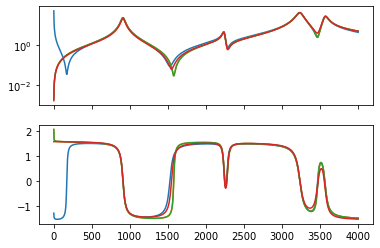

In [930]:
fig,ax=subplots(2,sharex=True)
ax[0].semilogy(f,np.abs(hf))
ax[1].plot(f,np.angle(hf))
ax[0].semilogy(f,np.abs(model(zvar,pf,zf,pcf)))
ax[1].plot(f,np.angle(model(zvar,pf,zf,pcf)))
ax[0].semilogy(f,np.abs(vft.model(zvar,pf,zf,pcf)))
ax[1].plot(f,np.angle(vft.model(zvar,pf,zf,pcf)))
ax[0].semilogy(f,np.abs(vft.model(zvar,pn,zn,pcn)))
ax[1].plot(f,np.angle(vft.model(zvar,pn,zn,pcn)))
# ax[0].semilogy(f,np.abs(vft.model(zvar,vft.poles0,vft.residues0,vft.poly_coefs0)))
# ax[1].plot(f,np.angle(vft.model(zvar,vft.poles0,vft.residues0,vft.poly_coefs0)))


In [931]:
pn,zn,pcn

(array([-279.54740186-20317.61200244j, -279.54740186+20317.61200244j,
        -202.77942464-22392.85747392j, -202.77942464+22392.85747392j,
        -151.77531304 -5715.40891384j, -151.77531304 +5715.40891384j,
        -102.36068884-14062.66967498j, -102.36068884+14062.66967498j]),
 array([10843.27168498-149.19117595j, 10843.27168498+149.19117595j,
         4911.24207068 -44.47395079j,  4911.24207068 +44.47395079j,
         3087.89584621 -82.00049476j,  3087.89584621 +82.00049476j,
          387.1173495   -2.81778634j,   387.1173495   +2.81778634j]),
 array([], dtype=float64))

In [932]:
vft.poles0,vft.residues0,vft.poly_coefs0

(array([-279.54740186-20317.61200244j, -279.54740186+20317.61200244j,
        -202.77942464-22392.85747392j, -202.77942464+22392.85747392j,
        -151.77531304 -5715.40891384j, -151.77531304 +5715.40891384j,
        -102.36068884-14062.66967498j, -102.36068884+14062.66967498j]),
 array([11079.947  +389.88745j , 11079.947  -389.88745j ,
         4954.0557 -847.72644j ,  4954.0557 +847.72644j ,
         3367.0415  -31.908728j,  3367.0415  +31.908728j,
          391.76886 -21.923462j,   391.76886 +21.923462j], dtype=complex64),
 array([], dtype=float32))

In [933]:
vft.recover_args(vft.x0)

(array([-279.54740186-20317.61200244j, -279.54740186+20317.61200244j,
        -202.77942464-22392.85747392j, -202.77942464+22392.85747392j,
        -151.77531304 -5715.40891384j, -151.77531304 +5715.40891384j,
        -102.36068884-14062.66967498j, -102.36068884+14062.66967498j]),
 array([11085.75543421-152.52747857j, 11085.75543421+152.52747857j,
         5025.85692531 -45.51185023j,  5025.85692531 +45.51185023j,
         3366.0059951  -89.38583771j,  3366.0059951  +89.38583771j,
          392.37141119  -2.8560301j ,   392.37141119  +2.8560301j ]),
 array([], dtype=float32))

In [942]:
duct.char_impedance

130664222.71873127

In [946]:
def get_pole(tract, n_poles=1):
    f=np.linspace(1,4000,1000)
    duct = get_impedance(tract,loss_multiplier=5)
    z=duct.get_input_impedance_at_freq(f)/duct.char_impedance

    # find region to fit to
    pks,_ = sig.find_peaks(np.abs(z),width=10)
    vls,_ = sig.find_peaks(-np.abs(z),width=10)
    if vls[0]>pks[0]:
        try:
            istop = int((vls[n_poles-1]+pks[n_poles-1])/2)
        except IndexError:
            istop = len(z)
        istart = 0
    else:
        istart=vls[0]
        try:
            istop = int((vls[n_poles]+pks[n_poles-1])/2)
        except IndexError:
            istop = len(z)
    istart=0
        
    print(f"First peak at {f[pks[0]]} Hz, fitting from {f[istart]} up to {f[istop-1]} Hz")

    hf=z
    s = 1j*2*np.pi*f
    zvar = s
    
    weights = f[istart:istop]**(-1)
    weights = np.abs(zvar[istart:istop])**(-.5)

    fres = 2*pi*f[pks[:n_poles]]
    fres = np.insert(fres, 0,0,)

    if len(fres)<n_poles:
        fres = np.concatenate([fres,fres[-1]+np.arange(1,n_poles-len(fres)+1)*4*np.median(np.diff(fres))])

    print(f"Init resonances {fres}")

    #pf,zf,pcf = vecfit_auto(hf[:istop],zvar[:istop],n_poles=n_poles,weights = weights,init_resonances=fres)#,force_residue="arg_pole"  )
    pf,zf,pcf = vecfit_auto(hf[istart:istop],zvar[istart:istop],
                            n_poles=n_poles+1,weights = weights,
                            init_resonances=fres)#,force_residue="arg_pole"  )

    # correct residue phase
    zfc = np.abs(zf)*np.exp(1j*(np.angle(pf)))
    zfc[zfc.imag>0]*=-1j
    zfc[zfc.imag<0]*=+1j
    #zf=-zfc

    vft = VFTweaker(hf[:istop],zvar[:istop],pf,zf,pcf,residues_only=True,copy_pole_phase=True)
    pn,zn,pcn = vft.optimize()
    
    if not vft.res.success:
        print('Failed fitting')
    #pn,zn,pcn = pf,zf,pcf
    
    return pn, zn, pcn, vft

{'phoneme': 'I', 'file': 'Story1996_male01_cm2.csv', 'units': 'cm2', 'gender': 'male', 'source': 'Story 1996', 'delta': 0.396285, 'length ': 16.67, 'measured_formants': {'f1': 518, 'f2': 2004, 'f3': 2605}}
First peak at 597.4474474474474 Hz, fitting from 1.0 up to 4000.0 Hz
Init resonances [    0.          3753.87302361  8155.4047129  17461.50028453
 23749.4026978 ]
poles: -268.804 + -3722.92j, -268.804 + 3722.92j, -216.969 + 0j, -215.711 + -7932.53j, -215.711 + 7932.53j, -67.1742 + 0j, -23.6251 + 0j, -3.69313 + 0j, -24.9662 + 0j, -183.279 + 0j
residues: 6346.7 + -465.603j, 6346.7 + 465.603j, 7898.9 + 0j, 191.782 + -43.4525j, 191.782 + 43.4525j, -2577.57 + 0j, 91727.9 + 0j, 9215.45 + 0j, -113859 + 0j, 16062.1 + 0j
polynomial coefs: 



/Users/goios/Devel/impedancepython/pympedance/Synthesiser.py:1004: RuntimeWarning: divide by zero encountered in true_divide
  return (1.+r)/(1.-r)


Failed fitting
Freq 594.0631465192372
Q    6.943003095832019
A    (0.005898320334146962+0j)
VecFit cost 3380.73
Fit cost 88.5697

First peak at 925.6936936936936 Hz, fitting from 1.0 up to 4000.0 Hz
Init resonances [    0.          5816.30501517  8457.22402874 17587.2583328
 23824.85752676]
poles: -350.887 + -17150.2j, -350.887 + 17150.2j, -321.583 + -8342j, -321.583 + 8342j, -304.257 + -5824.79j, -304.257 + 5824.79j, -141.755 + 0j, -31.0847 + 0j, -4.67937 + 0j, -33.6889 + 0j
residues: 357.027 + -138.833j, 357.027 + 138.833j, 2107.27 + -190.628j, 2107.27 + 190.628j, 7010.64 + 276.636j, 7010.64 + -276.636j, 552.587 + 0j, -21894.2 + 0j, -2906.53 + 0j, 27321.1 + 0j
polynomial coefs: 



/Users/goios/Devel/impedancepython/pympedance/Synthesiser.py:1004: RuntimeWarning: divide by zero encountered in true_divide
  return (1.+r)/(1.-r)
/Users/goios/Devel/impedancepython/pympedance/Synthesiser.py:1004: RuntimeWarning: divide by zero encountered in true_divide
  return (1.+r)/(1.-r)


Freq 928.3085230256773
Q    9.585224793599197
A    (0.003704409237813653+0j)
VecFit cost 1573.26
Fit cost 87.6903

First peak at 1141.855855855856 Hz, fitting from 1.0 up to 4000.0 Hz
Init resonances [    0.          7174.49193643 11374.81074849 18190.89696447
 23975.76718468]
poles: -487.702 + -11353.8j, -487.702 + 11353.8j, -482.088 + -18032.6j, -482.088 + 18032.6j, -241.737 + -7241.45j, -241.737 + 7241.45j, -127.056 + 0j, -30.8735 + 0j, -4.88419 + 0j, -34.3127 + 0j
residues: 7488.76 + -28.005j, 7488.76 + 28.005j, 2242.23 + -457.34j, 2242.23 + 457.34j, 948.588 + 40.2801j, 948.588 + -40.2801j, 186.989 + 0j, -4723.06 + 0j, -798.254 + 0j, 6190.9 + 0j
polynomial coefs: 



/Users/goios/Devel/impedancepython/pympedance/Synthesiser.py:1004: RuntimeWarning: divide by zero encountered in true_divide
  return (1.+r)/(1.-r)


Freq 1153.1538744469763
Q    14.986263135065137
A    (0.0004941339575196696+0j)
VecFit cost 651.872
Fit cost 224.274

First peak at 1161.870870870871 Hz, fitting from 1.0 up to 4000.0 Hz
Init resonances [    0.          7300.2499847  14845.73288062 21385.15139041]
poles: -608.272 + -21303.8j, -608.272 + 21303.8j, -379.059 + -14843.5j, -379.059 + 14843.5j, -21.0597 + 0j, -3.16753 + 0j, -7.45602 + 0j, -3179.31 + 0j
residues: 1992.62 + -2058.37j, 1992.62 + 2058.37j, 943.232 + -862.368j, 943.232 + 862.368j, -144.123 + 0j, 200.145 + 0j, -188.501 + 0j, 710.753 + 0j
polynomial coefs: 



/Users/goios/Devel/impedancepython/pympedance/Synthesiser.py:1004: RuntimeWarning: divide by zero encountered in true_divide
  return (1.+r)/(1.-r)


Failed fitting
Freq 2363.1854149648775
Q    19.585797297871576
A    (0.0001497047688860162+0j)
VecFit cost 1141.49
Fit cost 919.058

First peak at 1165.873873873874 Hz, fitting from 1.0 up to 4000.0 Hz
Init resonances [    0.          7325.40159435 15172.7038061  21913.33519313]
poles: -3568.2 + -31692.6j, -3568.2 + 31692.6j, -452.331 + -22254.6j, -452.331 + 22254.6j, -383.056 + -15371.8j, -383.056 + 15371.8j, -36.3286 + 0j, -5.24775 + 0j
residues: 24067.7 + -2196.85j, 24067.7 + 2196.85j, 346.687 + 194.105j, 346.687 + -194.105j, 263.717 + 52.0765j, 263.717 + -52.0765j, 8.97795 + 0j, 26.7862 + 0j
polynomial coefs: 



/Users/goios/Devel/impedancepython/pympedance/Synthesiser.py:1004: RuntimeWarning: divide by zero encountered in true_divide
  return (1.+r)/(1.-r)
/Users/goios/Devel/impedancepython/pympedance/Synthesiser.py:1004: RuntimeWarning: divide by zero encountered in true_divide
  return (1.+r)/(1.-r)


Freq 2447.25938939257
Q    20.0709320886267
A    (5.063326253102004e-05+0j)
VecFit cost 17.439
Fit cost 16.0687



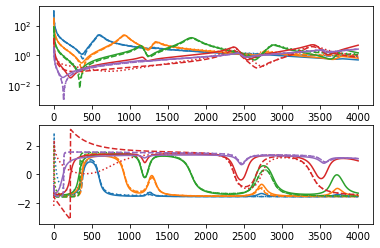

In [947]:
f = np.linspace(1,4000,1000)

ii=1
fig, ax = plt.subplots(2)

print (tractjs[ii]['headers'])

tongue_len = 1.4

for rad in [20,10,5,2,1]:
    tract = tractjs[ii].copy()
    dx = tract['headers']['delta']
    n_seg = int(np.round(tongue_len/dx))
    
    for jj in range(n_seg):
        tract['radii'][jj] = pi*(rad/10)**2
    
    
    
    duct = get_impedance(tract)
    all_poles, all_residues, pcs, vft = get_pole(tractjs[ii],n_poles=4)
    z = duct.get_input_impedance_at_freq(f)/duct.char_impedance
    lns=ax[0].semilogy(f, np.abs(z))
    ax[1].plot(f,np.angle(z),color=lns[0].get_color())
    
    s = 1j*2*np.pi*f
    zvar = s

    zf=vft.model(zvar,*vft.recover_args(vft.x0))
    
    ax[0].semilogy(f,np.abs(zf),color=lns[0].get_color(),ls=':')
    ax[1].plot(f,np.angle(zf),color=lns[0].get_color(),ls=':')
    
    zf=vft.model(zvar,all_poles,all_residues,pcs)
    
    ax[0].semilogy(f,np.abs(zf),color=lns[0].get_color(),ls='--')
    ax[1].plot(f,np.angle(zf),color=lns[0].get_color(),ls='--')
    
    idxc = np.where(np.imag(all_poles)>1e-3)[0]
    idxpole = idxc[np.argmin(np.abs(all_poles[idxc]))]
    idxp1 = np.abs(np.abs(all_poles)-np.abs(all_poles[idxpole]))<1e-3
    poles = all_poles[idxp1]
    residues = all_residues[idxp1]
    #poles = all_poles[idxpoles]
    
    denom = polyadd(polymul([residues[1]],[1,poles[0]]),polymul([residues[0]],[1,poles[1]]))
    numer = polymul(*[[1,-pp] for pp in poles])
    omega = np.real(np.sqrt(numer[2]))
    Q = np.real(omega/numer[1])
    #a*omegar**2/q
    print(f"Freq {omega/2/pi}")
    print(f"Q    {Q}")
    print(f"A    {denom[0]/omega**2*Q}")
    print(f"VecFit cost {vft.cost0:g}")
    print(f"Fit cost {vft.cost:g}")
    print()
    #print(f"Zc   {denom[0]/}")

In [939]:
vft.recover_args(vft.x0)

(array([  -36.327175      +0.j        ,    -5.24778457    +0.j        ,
        -3568.16505841-31692.60279576j, -3568.16505841+31692.60279576j,
         -452.33362693-22254.58025753j,  -452.33362693+22254.58025753j,
         -383.05641602-15371.80951952j,  -383.05641602+15371.80951952j]),
 array([1.17275200e+09+0.00000000e+00j, 3.50036173e+09+0.00000000e+00j,
        3.13803781e+12-3.53301272e+11j, 3.13803781e+12+3.53301272e+11j,
        5.19062267e+10-1.05501571e+09j, 5.19062267e+10+1.05501571e+09j,
        3.51131596e+10-8.74999203e+08j, 3.51131596e+10+8.74999203e+08j]),
 array([], dtype=float32))

In [940]:
vft.poles0,vft.residues0,vft.poly_coefs0

(array([-3568.16505841-31692.60279576j, -3568.16505841+31692.60279576j,
         -452.33362693-22254.58025753j,  -452.33362693+22254.58025753j,
         -383.05641602-15371.80951952j,  -383.05641602+15371.80951952j,
          -36.327175      +0.j        ,    -5.24778457    +0.j        ]),
 array([3.1447900e+12-2.8705128e+11j, 3.1447900e+12+2.8705128e+11j,
        4.5299929e+10+2.5363081e+10j, 4.5299929e+10-2.5363081e+10j,
        3.4458644e+10+6.8045056e+09j, 3.4458644e+10-6.8045056e+09j,
        1.1727520e+09+0.0000000e+00j, 3.5003617e+09+0.0000000e+00j],
       dtype=complex64),
 array([], dtype=float32))

In [809]:
np.abs(all_poles-all_poles[idxpole])

array([47570.73630992, 16995.56098776, 15486.79707559, 37624.92238249,
        6857.21928986, 30768.06049149,     0.        , 15387.34270003])

In [803]:
np.insert(fres,0,0)

array([    0.        ,  6143.27594065, 14694.8232227 , 22542.12543445,
       55339.82442205])